In [23]:
#!/usr/bin/python3.8

import subprocess
import matplotlib.pyplot as plot
import numpy
import sys
from optparse import OptionParser
import math
import copy
import random
# create estimation file
random.seed(1)
c_real = [[0,0,0],[2,0,math.pi/6]]

c0_vertex = [[1,-1,0], [1,0,0],[1,1,math.pi/4]]
c1_vertex = [[0,1,0], [-1,1,math.pi/6],[-1,0,math.pi/10]] # in frame 2

c1_vertex_world = []
for vertex in c1_vertex:
    tmp = []
    theta = c_real[1][-1]
    tmp.append(math.cos(theta) * vertex[0] - math.sin(theta) * vertex[1] + c_real[1][0])
    tmp.append(math.sin(theta) * vertex[0] + math.cos(theta) * vertex[1] + c_real[1][1])
    tmp.append(theta + vertex[2])
    c1_vertex_world.append(tmp)

estimate_vertex = []
estimate_id = [[2,3,4],[5,6,7]]
for v1,v2 in zip(c0_vertex,c1_vertex_world):
    theta = v1[-1]
    tmp = []
    pos_x = v2[0] - v1[0]
    pos_y = v2[1] - v1[1]
    tmp.append(math.cos(theta) * pos_x + math.sin(theta) * pos_y )
    tmp.append(-math.sin(theta) * pos_x + math.cos(theta) * pos_y )
    tmp.append(v2[2] - v1[2])
    estimate_vertex.append(tmp)

#create g2o file
self_g2o_file = "self.g2o"
vertex_id = 0

c_real[1] = [0,0,0]
with open(self_g2o_file, "w") as f:
    for center in c_real:
        f.write("VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(vertex_id,center[0],center[1],center[2]))
        vertex_id +=1
    for vertex in c0_vertex:
        f.write("VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(vertex_id,vertex[0],vertex[1],vertex[2]))
        vertex_id +=1
    for vertex in c1_vertex_world:
        f.write("VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(vertex_id,vertex[0],vertex[1],vertex[2]))
        vertex_id +=1
    
    #write edge
    now_vertex = 2
    trust = 1
    for vertex in c0_vertex:
        f.write("EDGE_SE2 0 {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(now_vertex,vertex[0],vertex[1],vertex[2],trust,trust,trust))
        now_vertex +=1
    now_vertex = 5
    trust = 1
    for vertex in c1_vertex:
        f.write("EDGE_SE2 1 {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(now_vertex,vertex[0],vertex[1],vertex[2],trust,trust,trust))
        now_vertex +=1

    # write relative pose estimation
    #need to add noisy
    idx = 0
    trust = 10000
    for vertex in estimate_vertex:
        f.write("EDGE_SE2 {} {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(estimate_id[0][idx],estimate_id[1][idx],
        vertex[0] + random.uniform(0, 1)/10,vertex[1]+ random.uniform(0, 1)/10,vertex[2]+ random.uniform(0, 1)/5,trust,trust,trust))
        idx +=1


# 调用可执行文件并等待其完成
executable_file_path = "./pose_graph_2d"
# input_file_path = "input_MITb_g2o.g2o"
process = subprocess.Popen([executable_file_path,"--input",self_g2o_file], stdout=subprocess.PIPE)
output, error = process.communicate()

# 输出结果
print("Optimized Pose")
print(output.decode())


Optimized Pose
0 0 0 0
1 2.05429 0.162558 0.612949
2 0.977455 -0.983708 -0.00547283
3 1.00087 -0.00509813 0.000412722
4 1.02167 0.988806 0.834671
5 1.50156 0.964223 0.670875
6 0.660183 0.41033 1.13751
7 1.21466 -0.401531 0.905806



In [39]:
trans_data = ""
vertex_id = 0
for center in c_real:
    trans_data+="VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(vertex_id,center[0],center[1],center[2])
    vertex_id +=1
for vertex in c0_vertex:
    trans_data+="VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(vertex_id,vertex[0],vertex[1],vertex[2])
    vertex_id +=1
for vertex in c1_vertex_world:
    trans_data+="VERTEX_SE2 {} {:.6f} {:.6f} {:.6f}\n".format(vertex_id,vertex[0],vertex[1],vertex[2])
    vertex_id +=1

#write edge
now_vertex = 2
trust = 1
for vertex in c0_vertex:
    trans_data+="EDGE_SE2 0 {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(now_vertex,vertex[0],vertex[1],vertex[2],trust,trust,trust)
    now_vertex +=1
now_vertex = 5
trust = 1
for vertex in c1_vertex:
    trans_data+="EDGE_SE2 1 {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(now_vertex,vertex[0],vertex[1],vertex[2],trust,trust,trust)
    now_vertex +=1

# write relative pose estimation
#need to add noisy
idx = 0
trust = 10000
for vertex in estimate_vertex:
    trans_data+="EDGE_SE2 {} {} {:.6f} {:.6f} {:.6f} {:.6f} 0 0 {:.6f} 0 {:.6f}\n".format(estimate_id[0][idx],estimate_id[1][idx],
    vertex[0] + random.uniform(0, 1)/10,vertex[1]+ random.uniform(0, 1)/10,vertex[2]+ random.uniform(0, 1)/5,trust,trust,trust)
    idx +=1

process = subprocess.Popen("./test", stdin=subprocess.PIPE, stdout=subprocess.PIPE, text=True)

# 向C++程序输入数据
process.stdin.write(trans_data)

# 关闭输入流
process.stdin.close()

output_data = process.stdout.readline()
while output_data:
    print(output_data, end='')
    output_data = process.stdout.readline()

# 等待C++程序退出
process.wait()



0 0 0 0

1 2.03762 0.0998448 0.571043

2 0.981718 -0.997126 -0.0032966

3 0.999293 -0.00265161 0.0219528

4 1.01898 0.999769 0.80396

5 1.51539 0.938309 0.611238

6 0.656474 0.403324 1.07388

7 1.17729 -0.440444 0.893927



0

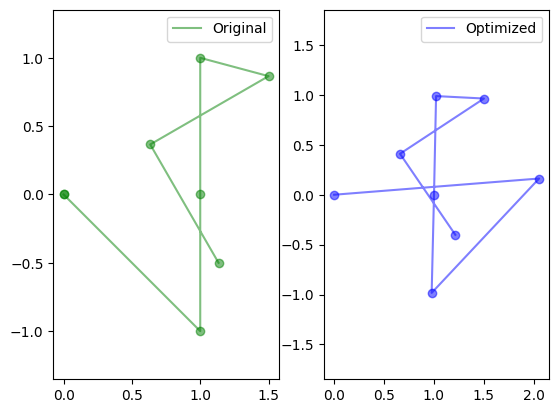

In [24]:
import matplotlib.pyplot as plot
import numpy
import sys
from optparse import OptionParser


# Read the original and optimized poses files.
poses_original = None

poses_original = numpy.genfromtxt("poses_original.txt", usecols = (1, 2))

poses_optimized = None
poses_optimized = numpy.genfromtxt("poses_optimized.txt", usecols = (1, 2))

# Plots the results for the specified poses.
plot.figure()
plot.subplot(121)
plot.plot(poses_original[:, 0], poses_original[:, 1], '-', label="Original",
            alpha=0.5, color="green")
plot.scatter(poses_original[:, 0], poses_original[:, 1],
alpha=0.5, color="green")
plot.axis('equal')
plot.legend()
plot.subplot(122)
plot.plot(poses_optimized[:, 0], poses_optimized[:, 1], '-', label="Optimized",
            alpha=0.5, color="blue")
plot.scatter(poses_optimized[:, 0], poses_optimized[:, 1],
            alpha=0.5, color="blue")
plot.axis('equal')
plot.legend()
# Show the plot and wait for the user to close.
plot.show()
